# HAR CNN training 

In [1]:
# Imports
import numpy as np
import os
from utils.semg_utilities import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

## Prepare data

In [2]:
path = os.path.abspath(os.getcwd())
X_train, labels_train, list_ch_train = read_data(data_path= path + os.sep + "sEMG" + os.sep + "Database 2" + os.sep, split_type="train") # train
X_test, labels_test, list_ch_test = read_data(data_path= path + os.sep + "sEMG" + os.sep + "Database 2" + os.sep, split_type="test") # test

assert list_ch_train == list_ch_test, "Mistmatch in channels!"

In [3]:
# Normalize?
X_train, X_test = standardize(X_train, X_test)

Train/Validation Split

In [4]:
X_tr, X_vld, lab_tr, lab_vld = train_test_split(X_train, labels_train, 
                                                stratify = labels_train, random_state = 123)

One-hot encoding:

In [5]:
y_tr = one_hot(lab_tr)
y_vld = one_hot(lab_vld)
y_test = one_hot(labels_test)

In [6]:
# Imports
import tensorflow as tf

### Hyperparameters

In [7]:
batch_size = 100       # Batch size
seq_len = 2496          # Number of steps
learning_rate = 0.00001
epochs = 1000

n_classes = 6
n_channels = 2

### Construct the graph
Placeholders

In [8]:
graph = tf.Graph()

# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

Build Convolutional Layers

Note: Should we use a different activation? Like tf.nn.tanh?

In [9]:
with graph.as_default():
    # (batch, 2496, 2) --> (batch, 1248, 4)
    conv1 = tf.layers.conv1d(inputs=inputs_, filters=4, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')
    
    # (batch, 1248, 4) --> (batch, 624, 8)
    conv2 = tf.layers.conv1d(inputs=max_pool_1, filters=8, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2, padding='same')
    
    # (batch, 624, 8) --> (batch, 312, 16)
    conv3 = tf.layers.conv1d(inputs=max_pool_2, filters=16, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=2, strides=2, padding='same')
    
    # (batch, 312, 16) --> (batch, 156, 32)
    conv4 = tf.layers.conv1d(inputs=max_pool_3, filters=32, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_4 = tf.layers.max_pooling1d(inputs=conv4, pool_size=2, strides=2, padding='same')
    
    # (batch, 156, 32) --> (batch, 78, 64)
    conv5 = tf.layers.conv1d(inputs=max_pool_4, filters=64, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_5 = tf.layers.max_pooling1d(inputs=conv5, pool_size=2, strides=2, padding='same')
    
    # (batch, 78, 64) --> (batch, 39, 128)
    conv6 = tf.layers.conv1d(inputs=max_pool_5, filters=128, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_6 = tf.layers.max_pooling1d(inputs=conv6, pool_size=2, strides=2, padding='same')
    

Now, flatten and pass to the classifier

In [10]:
with graph.as_default():
    # Flatten and add dropout
    flat = tf.reshape(max_pool_6, (-1, 128 * 39))
    flat = tf.nn.dropout(flat, keep_prob=keep_prob_)
    
    # Predictions
    logits = tf.layers.dense(flat, n_classes)
    
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

### Train the network

In [11]:
if (os.path.exists('checkpoints-cnn') == False):
    !mkdir checkpoints-cnn

In [12]:
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over batches
        for x,y in get_batches(X_tr, y_tr, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, learning_rate_ : learning_rate}
            
            # Loss
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 10 iterations
            if (iteration%10 == 0):                
                val_acc_ = []
                val_loss_ = []
                
                for x_v, y_v in get_batches(X_vld, y_vld, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0}  
                    
                    # Loss
                    loss_v, acc_v = sess.run([cost, accuracy], feed_dict = feed)                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1
    
    saver.save(sess,"checkpoints-cnn/har.ckpt")

Epoch: 0/1000 Iteration: 5 Train loss: 1.821700 Train acc: 0.140000
Epoch: 0/1000 Iteration: 10 Train loss: 1.765165 Train acc: 0.220000
Epoch: 0/1000 Iteration: 10 Validation loss: 1.760393 Validation acc: 0.202500
Epoch: 1/1000 Iteration: 15 Train loss: 1.731881 Train acc: 0.150000
Epoch: 1/1000 Iteration: 20 Train loss: 1.757083 Train acc: 0.150000
Epoch: 1/1000 Iteration: 20 Validation loss: 1.711560 Validation acc: 0.207500
Epoch: 1/1000 Iteration: 25 Train loss: 1.691540 Train acc: 0.270000
Epoch: 2/1000 Iteration: 30 Train loss: 1.746221 Train acc: 0.140000
Epoch: 2/1000 Iteration: 30 Validation loss: 1.687833 Validation acc: 0.240000
Epoch: 2/1000 Iteration: 35 Train loss: 1.744588 Train acc: 0.160000
Epoch: 3/1000 Iteration: 40 Train loss: 1.730822 Train acc: 0.170000
Epoch: 3/1000 Iteration: 40 Validation loss: 1.668987 Validation acc: 0.240000
Epoch: 3/1000 Iteration: 45 Train loss: 1.605417 Train acc: 0.300000
Epoch: 3/1000 Iteration: 50 Train loss: 1.649881 Train acc: 0.26

Epoch: 30/1000 Iteration: 395 Train loss: 0.794756 Train acc: 0.690000
Epoch: 30/1000 Iteration: 400 Train loss: 0.828656 Train acc: 0.650000
Epoch: 30/1000 Iteration: 400 Validation loss: 0.791665 Validation acc: 0.717500
Epoch: 31/1000 Iteration: 405 Train loss: 0.752109 Train acc: 0.720000
Epoch: 31/1000 Iteration: 410 Train loss: 0.833594 Train acc: 0.660000
Epoch: 31/1000 Iteration: 410 Validation loss: 0.782164 Validation acc: 0.712500
Epoch: 31/1000 Iteration: 415 Train loss: 0.759745 Train acc: 0.780000
Epoch: 32/1000 Iteration: 420 Train loss: 0.716864 Train acc: 0.740000
Epoch: 32/1000 Iteration: 420 Validation loss: 0.772669 Validation acc: 0.715000
Epoch: 32/1000 Iteration: 425 Train loss: 0.715084 Train acc: 0.720000
Epoch: 33/1000 Iteration: 430 Train loss: 0.738482 Train acc: 0.740000
Epoch: 33/1000 Iteration: 430 Validation loss: 0.770271 Validation acc: 0.720000
Epoch: 33/1000 Iteration: 435 Train loss: 0.633273 Train acc: 0.810000
Epoch: 33/1000 Iteration: 440 Train l

Epoch: 59/1000 Iteration: 780 Train loss: 0.581159 Train acc: 0.800000
Epoch: 59/1000 Iteration: 780 Validation loss: 0.544758 Validation acc: 0.807500
Epoch: 60/1000 Iteration: 785 Train loss: 0.463058 Train acc: 0.870000
Epoch: 60/1000 Iteration: 790 Train loss: 0.512471 Train acc: 0.770000
Epoch: 60/1000 Iteration: 790 Validation loss: 0.540995 Validation acc: 0.805000
Epoch: 61/1000 Iteration: 795 Train loss: 0.487737 Train acc: 0.790000
Epoch: 61/1000 Iteration: 800 Train loss: 0.554630 Train acc: 0.800000
Epoch: 61/1000 Iteration: 800 Validation loss: 0.534055 Validation acc: 0.810000
Epoch: 61/1000 Iteration: 805 Train loss: 0.514458 Train acc: 0.840000
Epoch: 62/1000 Iteration: 810 Train loss: 0.460532 Train acc: 0.840000
Epoch: 62/1000 Iteration: 810 Validation loss: 0.526307 Validation acc: 0.817500
Epoch: 62/1000 Iteration: 815 Train loss: 0.432603 Train acc: 0.870000
Epoch: 63/1000 Iteration: 820 Train loss: 0.490806 Train acc: 0.840000
Epoch: 63/1000 Iteration: 820 Validat

Epoch: 88/1000 Iteration: 1145 Train loss: 0.386949 Train acc: 0.870000
Epoch: 88/1000 Iteration: 1150 Train loss: 0.367303 Train acc: 0.880000
Epoch: 88/1000 Iteration: 1150 Validation loss: 0.409417 Validation acc: 0.875000
Epoch: 88/1000 Iteration: 1155 Train loss: 0.478962 Train acc: 0.860000
Epoch: 89/1000 Iteration: 1160 Train loss: 0.277444 Train acc: 0.920000
Epoch: 89/1000 Iteration: 1160 Validation loss: 0.410219 Validation acc: 0.875000
Epoch: 89/1000 Iteration: 1165 Train loss: 0.242100 Train acc: 0.930000
Epoch: 89/1000 Iteration: 1170 Train loss: 0.401304 Train acc: 0.840000
Epoch: 89/1000 Iteration: 1170 Validation loss: 0.407490 Validation acc: 0.875000
Epoch: 90/1000 Iteration: 1175 Train loss: 0.302616 Train acc: 0.910000
Epoch: 90/1000 Iteration: 1180 Train loss: 0.316847 Train acc: 0.890000
Epoch: 90/1000 Iteration: 1180 Validation loss: 0.405591 Validation acc: 0.875000
Epoch: 91/1000 Iteration: 1185 Train loss: 0.320006 Train acc: 0.900000
Epoch: 91/1000 Iteration

Epoch: 116/1000 Iteration: 1520 Train loss: 0.199277 Train acc: 0.950000
Epoch: 116/1000 Iteration: 1520 Validation loss: 0.366405 Validation acc: 0.882500
Epoch: 117/1000 Iteration: 1525 Train loss: 0.253751 Train acc: 0.920000
Epoch: 117/1000 Iteration: 1530 Train loss: 0.266625 Train acc: 0.900000
Epoch: 117/1000 Iteration: 1530 Validation loss: 0.365561 Validation acc: 0.882500
Epoch: 118/1000 Iteration: 1535 Train loss: 0.284495 Train acc: 0.910000
Epoch: 118/1000 Iteration: 1540 Train loss: 0.271886 Train acc: 0.910000
Epoch: 118/1000 Iteration: 1540 Validation loss: 0.366982 Validation acc: 0.880000
Epoch: 118/1000 Iteration: 1545 Train loss: 0.322096 Train acc: 0.870000
Epoch: 119/1000 Iteration: 1550 Train loss: 0.191960 Train acc: 0.960000
Epoch: 119/1000 Iteration: 1550 Validation loss: 0.365849 Validation acc: 0.882500
Epoch: 119/1000 Iteration: 1555 Train loss: 0.193545 Train acc: 0.930000
Epoch: 119/1000 Iteration: 1560 Train loss: 0.296342 Train acc: 0.910000
Epoch: 119/

Epoch: 144/1000 Iteration: 1885 Train loss: 0.277233 Train acc: 0.900000
Epoch: 145/1000 Iteration: 1890 Train loss: 0.173220 Train acc: 0.970000
Epoch: 145/1000 Iteration: 1890 Validation loss: 0.354234 Validation acc: 0.877500
Epoch: 145/1000 Iteration: 1895 Train loss: 0.210206 Train acc: 0.930000
Epoch: 146/1000 Iteration: 1900 Train loss: 0.187925 Train acc: 0.940000
Epoch: 146/1000 Iteration: 1900 Validation loss: 0.356414 Validation acc: 0.875000
Epoch: 146/1000 Iteration: 1905 Train loss: 0.229597 Train acc: 0.920000
Epoch: 146/1000 Iteration: 1910 Train loss: 0.139293 Train acc: 0.970000
Epoch: 146/1000 Iteration: 1910 Validation loss: 0.352509 Validation acc: 0.877500
Epoch: 147/1000 Iteration: 1915 Train loss: 0.170791 Train acc: 0.950000
Epoch: 147/1000 Iteration: 1920 Train loss: 0.183688 Train acc: 0.940000
Epoch: 147/1000 Iteration: 1920 Validation loss: 0.360639 Validation acc: 0.877500
Epoch: 148/1000 Iteration: 1925 Train loss: 0.220959 Train acc: 0.900000
Epoch: 148/

Epoch: 173/1000 Iteration: 2250 Train loss: 0.195914 Train acc: 0.920000
Epoch: 173/1000 Iteration: 2250 Validation loss: 0.359008 Validation acc: 0.882500
Epoch: 173/1000 Iteration: 2255 Train loss: 0.178557 Train acc: 0.910000
Epoch: 173/1000 Iteration: 2260 Train loss: 0.272355 Train acc: 0.890000
Epoch: 173/1000 Iteration: 2260 Validation loss: 0.350353 Validation acc: 0.880000
Epoch: 174/1000 Iteration: 2265 Train loss: 0.132722 Train acc: 0.960000
Epoch: 174/1000 Iteration: 2270 Train loss: 0.135716 Train acc: 0.970000
Epoch: 174/1000 Iteration: 2270 Validation loss: 0.348723 Validation acc: 0.882500
Epoch: 174/1000 Iteration: 2275 Train loss: 0.244959 Train acc: 0.900000
Epoch: 175/1000 Iteration: 2280 Train loss: 0.151392 Train acc: 0.950000
Epoch: 175/1000 Iteration: 2280 Validation loss: 0.358922 Validation acc: 0.880000
Epoch: 175/1000 Iteration: 2285 Train loss: 0.163136 Train acc: 0.960000
Epoch: 176/1000 Iteration: 2290 Train loss: 0.182259 Train acc: 0.920000
Epoch: 176/

Epoch: 200/1000 Iteration: 2610 Train loss: 0.152239 Train acc: 0.940000
Epoch: 200/1000 Iteration: 2610 Validation loss: 0.352110 Validation acc: 0.882500
Epoch: 201/1000 Iteration: 2615 Train loss: 0.146458 Train acc: 0.950000
Epoch: 201/1000 Iteration: 2620 Train loss: 0.152179 Train acc: 0.950000
Epoch: 201/1000 Iteration: 2620 Validation loss: 0.349607 Validation acc: 0.882500
Epoch: 201/1000 Iteration: 2625 Train loss: 0.125795 Train acc: 0.970000
Epoch: 202/1000 Iteration: 2630 Train loss: 0.142984 Train acc: 0.950000
Epoch: 202/1000 Iteration: 2630 Validation loss: 0.366037 Validation acc: 0.882500
Epoch: 202/1000 Iteration: 2635 Train loss: 0.125245 Train acc: 0.970000
Epoch: 203/1000 Iteration: 2640 Train loss: 0.189189 Train acc: 0.930000
Epoch: 203/1000 Iteration: 2640 Validation loss: 0.350580 Validation acc: 0.885000
Epoch: 203/1000 Iteration: 2645 Train loss: 0.146623 Train acc: 0.940000
Epoch: 203/1000 Iteration: 2650 Train loss: 0.251506 Train acc: 0.890000
Epoch: 203/

Epoch: 228/1000 Iteration: 2975 Train loss: 0.208836 Train acc: 0.910000
Epoch: 229/1000 Iteration: 2980 Train loss: 0.082590 Train acc: 0.970000
Epoch: 229/1000 Iteration: 2980 Validation loss: 0.366588 Validation acc: 0.880000
Epoch: 229/1000 Iteration: 2985 Train loss: 0.129816 Train acc: 0.950000
Epoch: 229/1000 Iteration: 2990 Train loss: 0.183781 Train acc: 0.910000
Epoch: 229/1000 Iteration: 2990 Validation loss: 0.362488 Validation acc: 0.887500
Epoch: 230/1000 Iteration: 2995 Train loss: 0.144369 Train acc: 0.940000
Epoch: 230/1000 Iteration: 3000 Train loss: 0.099711 Train acc: 0.980000
Epoch: 230/1000 Iteration: 3000 Validation loss: 0.365451 Validation acc: 0.892500
Epoch: 231/1000 Iteration: 3005 Train loss: 0.119069 Train acc: 0.960000
Epoch: 231/1000 Iteration: 3010 Train loss: 0.123663 Train acc: 0.960000
Epoch: 231/1000 Iteration: 3010 Validation loss: 0.368672 Validation acc: 0.882500
Epoch: 231/1000 Iteration: 3015 Train loss: 0.131208 Train acc: 0.930000
Epoch: 232/

Epoch: 256/1000 Iteration: 3335 Train loss: 0.080947 Train acc: 0.990000
Epoch: 256/1000 Iteration: 3340 Train loss: 0.107879 Train acc: 0.950000
Epoch: 256/1000 Iteration: 3340 Validation loss: 0.375650 Validation acc: 0.890000
Epoch: 257/1000 Iteration: 3345 Train loss: 0.142389 Train acc: 0.950000
Epoch: 257/1000 Iteration: 3350 Train loss: 0.137852 Train acc: 0.950000
Epoch: 257/1000 Iteration: 3350 Validation loss: 0.376601 Validation acc: 0.890000
Epoch: 258/1000 Iteration: 3355 Train loss: 0.155379 Train acc: 0.910000
Epoch: 258/1000 Iteration: 3360 Train loss: 0.099820 Train acc: 0.980000
Epoch: 258/1000 Iteration: 3360 Validation loss: 0.378187 Validation acc: 0.885000
Epoch: 258/1000 Iteration: 3365 Train loss: 0.193919 Train acc: 0.940000
Epoch: 259/1000 Iteration: 3370 Train loss: 0.080021 Train acc: 0.990000
Epoch: 259/1000 Iteration: 3370 Validation loss: 0.375591 Validation acc: 0.885000
Epoch: 259/1000 Iteration: 3375 Train loss: 0.093878 Train acc: 0.970000
Epoch: 259/

Epoch: 284/1000 Iteration: 3700 Train loss: 0.050854 Train acc: 0.980000
Epoch: 284/1000 Iteration: 3700 Validation loss: 0.381979 Validation acc: 0.887500
Epoch: 284/1000 Iteration: 3705 Train loss: 0.099078 Train acc: 0.980000
Epoch: 285/1000 Iteration: 3710 Train loss: 0.086372 Train acc: 0.980000
Epoch: 285/1000 Iteration: 3710 Validation loss: 0.407645 Validation acc: 0.872500
Epoch: 285/1000 Iteration: 3715 Train loss: 0.088700 Train acc: 0.980000
Epoch: 286/1000 Iteration: 3720 Train loss: 0.070632 Train acc: 0.990000
Epoch: 286/1000 Iteration: 3720 Validation loss: 0.390856 Validation acc: 0.892500
Epoch: 286/1000 Iteration: 3725 Train loss: 0.104516 Train acc: 0.940000
Epoch: 286/1000 Iteration: 3730 Train loss: 0.076483 Train acc: 0.980000
Epoch: 286/1000 Iteration: 3730 Validation loss: 0.389353 Validation acc: 0.892500
Epoch: 287/1000 Iteration: 3735 Train loss: 0.102384 Train acc: 0.960000
Epoch: 287/1000 Iteration: 3740 Train loss: 0.098117 Train acc: 0.970000
Epoch: 287/

Epoch: 312/1000 Iteration: 4065 Train loss: 0.091131 Train acc: 0.950000
Epoch: 313/1000 Iteration: 4070 Train loss: 0.089916 Train acc: 0.960000
Epoch: 313/1000 Iteration: 4070 Validation loss: 0.403897 Validation acc: 0.890000
Epoch: 313/1000 Iteration: 4075 Train loss: 0.073575 Train acc: 0.980000
Epoch: 313/1000 Iteration: 4080 Train loss: 0.114470 Train acc: 0.970000
Epoch: 313/1000 Iteration: 4080 Validation loss: 0.395641 Validation acc: 0.890000
Epoch: 314/1000 Iteration: 4085 Train loss: 0.056777 Train acc: 0.990000
Epoch: 314/1000 Iteration: 4090 Train loss: 0.050773 Train acc: 0.990000
Epoch: 314/1000 Iteration: 4090 Validation loss: 0.413382 Validation acc: 0.885000
Epoch: 314/1000 Iteration: 4095 Train loss: 0.080516 Train acc: 0.990000
Epoch: 315/1000 Iteration: 4100 Train loss: 0.071796 Train acc: 0.980000
Epoch: 315/1000 Iteration: 4100 Validation loss: 0.404541 Validation acc: 0.895000
Epoch: 315/1000 Iteration: 4105 Train loss: 0.080428 Train acc: 0.970000
Epoch: 316/

Epoch: 340/1000 Iteration: 4430 Train loss: 0.097654 Train acc: 0.960000
Epoch: 340/1000 Iteration: 4430 Validation loss: 0.434611 Validation acc: 0.870000
Epoch: 341/1000 Iteration: 4435 Train loss: 0.048397 Train acc: 1.000000
Epoch: 341/1000 Iteration: 4440 Train loss: 0.067062 Train acc: 0.980000
Epoch: 341/1000 Iteration: 4440 Validation loss: 0.420481 Validation acc: 0.885000
Epoch: 341/1000 Iteration: 4445 Train loss: 0.064784 Train acc: 0.980000
Epoch: 342/1000 Iteration: 4450 Train loss: 0.047659 Train acc: 0.990000
Epoch: 342/1000 Iteration: 4450 Validation loss: 0.431995 Validation acc: 0.882500
Epoch: 342/1000 Iteration: 4455 Train loss: 0.076540 Train acc: 0.960000
Epoch: 343/1000 Iteration: 4460 Train loss: 0.049607 Train acc: 0.990000
Epoch: 343/1000 Iteration: 4460 Validation loss: 0.420100 Validation acc: 0.892500
Epoch: 343/1000 Iteration: 4465 Train loss: 0.079720 Train acc: 0.960000
Epoch: 343/1000 Iteration: 4470 Train loss: 0.135436 Train acc: 0.960000
Epoch: 343/

Epoch: 368/1000 Iteration: 4790 Train loss: 0.047798 Train acc: 0.990000
Epoch: 368/1000 Iteration: 4790 Validation loss: 0.452453 Validation acc: 0.877500
Epoch: 368/1000 Iteration: 4795 Train loss: 0.071781 Train acc: 0.980000
Epoch: 369/1000 Iteration: 4800 Train loss: 0.051087 Train acc: 0.990000
Epoch: 369/1000 Iteration: 4800 Validation loss: 0.435713 Validation acc: 0.890000
Epoch: 369/1000 Iteration: 4805 Train loss: 0.040417 Train acc: 0.990000
Epoch: 369/1000 Iteration: 4810 Train loss: 0.055839 Train acc: 1.000000
Epoch: 369/1000 Iteration: 4810 Validation loss: 0.434430 Validation acc: 0.880000
Epoch: 370/1000 Iteration: 4815 Train loss: 0.060376 Train acc: 0.990000
Epoch: 370/1000 Iteration: 4820 Train loss: 0.050372 Train acc: 1.000000
Epoch: 370/1000 Iteration: 4820 Validation loss: 0.446607 Validation acc: 0.890000
Epoch: 371/1000 Iteration: 4825 Train loss: 0.075189 Train acc: 0.970000
Epoch: 371/1000 Iteration: 4830 Train loss: 0.046541 Train acc: 1.000000
Epoch: 371/

Epoch: 396/1000 Iteration: 5160 Train loss: 0.043361 Train acc: 0.980000
Epoch: 396/1000 Iteration: 5160 Validation loss: 0.441494 Validation acc: 0.887500
Epoch: 397/1000 Iteration: 5165 Train loss: 0.052122 Train acc: 0.970000
Epoch: 397/1000 Iteration: 5170 Train loss: 0.048447 Train acc: 0.980000
Epoch: 397/1000 Iteration: 5170 Validation loss: 0.451853 Validation acc: 0.887500
Epoch: 398/1000 Iteration: 5175 Train loss: 0.043570 Train acc: 0.990000
Epoch: 398/1000 Iteration: 5180 Train loss: 0.042582 Train acc: 0.990000
Epoch: 398/1000 Iteration: 5180 Validation loss: 0.447118 Validation acc: 0.882500
Epoch: 398/1000 Iteration: 5185 Train loss: 0.116285 Train acc: 0.960000
Epoch: 399/1000 Iteration: 5190 Train loss: 0.053094 Train acc: 0.980000
Epoch: 399/1000 Iteration: 5190 Validation loss: 0.462825 Validation acc: 0.885000
Epoch: 399/1000 Iteration: 5195 Train loss: 0.044115 Train acc: 0.990000
Epoch: 399/1000 Iteration: 5200 Train loss: 0.045389 Train acc: 1.000000
Epoch: 399/

Epoch: 425/1000 Iteration: 5530 Train loss: 0.035916 Train acc: 0.990000
Epoch: 425/1000 Iteration: 5530 Validation loss: 0.479803 Validation acc: 0.882500
Epoch: 425/1000 Iteration: 5535 Train loss: 0.039167 Train acc: 1.000000
Epoch: 426/1000 Iteration: 5540 Train loss: 0.036685 Train acc: 0.990000
Epoch: 426/1000 Iteration: 5540 Validation loss: 0.496468 Validation acc: 0.877500
Epoch: 426/1000 Iteration: 5545 Train loss: 0.032499 Train acc: 1.000000
Epoch: 426/1000 Iteration: 5550 Train loss: 0.031559 Train acc: 0.990000
Epoch: 426/1000 Iteration: 5550 Validation loss: 0.464971 Validation acc: 0.877500
Epoch: 427/1000 Iteration: 5555 Train loss: 0.039704 Train acc: 0.990000
Epoch: 427/1000 Iteration: 5560 Train loss: 0.049708 Train acc: 0.980000
Epoch: 427/1000 Iteration: 5560 Validation loss: 0.472114 Validation acc: 0.885000
Epoch: 428/1000 Iteration: 5565 Train loss: 0.053972 Train acc: 0.980000
Epoch: 428/1000 Iteration: 5570 Train loss: 0.029324 Train acc: 0.990000
Epoch: 428/

Epoch: 453/1000 Iteration: 5890 Train loss: 0.020422 Train acc: 1.000000
Epoch: 453/1000 Iteration: 5890 Validation loss: 0.489059 Validation acc: 0.885000
Epoch: 453/1000 Iteration: 5895 Train loss: 0.041316 Train acc: 0.990000
Epoch: 453/1000 Iteration: 5900 Train loss: 0.046365 Train acc: 0.990000
Epoch: 453/1000 Iteration: 5900 Validation loss: 0.494643 Validation acc: 0.887500
Epoch: 454/1000 Iteration: 5905 Train loss: 0.051950 Train acc: 0.990000
Epoch: 454/1000 Iteration: 5910 Train loss: 0.025732 Train acc: 0.990000
Epoch: 454/1000 Iteration: 5910 Validation loss: 0.480272 Validation acc: 0.887500
Epoch: 454/1000 Iteration: 5915 Train loss: 0.043891 Train acc: 0.990000
Epoch: 455/1000 Iteration: 5920 Train loss: 0.043962 Train acc: 0.990000
Epoch: 455/1000 Iteration: 5920 Validation loss: 0.487191 Validation acc: 0.885000
Epoch: 455/1000 Iteration: 5925 Train loss: 0.026875 Train acc: 1.000000
Epoch: 456/1000 Iteration: 5930 Train loss: 0.032556 Train acc: 0.980000
Epoch: 456/

Epoch: 481/1000 Iteration: 6265 Train loss: 0.029241 Train acc: 0.990000
Epoch: 482/1000 Iteration: 6270 Train loss: 0.029876 Train acc: 0.990000
Epoch: 482/1000 Iteration: 6270 Validation loss: 0.534965 Validation acc: 0.872500
Epoch: 482/1000 Iteration: 6275 Train loss: 0.025321 Train acc: 1.000000
Epoch: 483/1000 Iteration: 6280 Train loss: 0.069272 Train acc: 0.990000
Epoch: 483/1000 Iteration: 6280 Validation loss: 0.505040 Validation acc: 0.882500
Epoch: 483/1000 Iteration: 6285 Train loss: 0.027242 Train acc: 1.000000
Epoch: 483/1000 Iteration: 6290 Train loss: 0.083847 Train acc: 0.960000
Epoch: 483/1000 Iteration: 6290 Validation loss: 0.499454 Validation acc: 0.880000
Epoch: 484/1000 Iteration: 6295 Train loss: 0.030189 Train acc: 0.990000
Epoch: 484/1000 Iteration: 6300 Train loss: 0.018832 Train acc: 0.990000
Epoch: 484/1000 Iteration: 6300 Validation loss: 0.508122 Validation acc: 0.885000
Epoch: 484/1000 Iteration: 6305 Train loss: 0.042905 Train acc: 0.990000
Epoch: 485/

Epoch: 510/1000 Iteration: 6635 Train loss: 0.034134 Train acc: 1.000000
Epoch: 510/1000 Iteration: 6640 Train loss: 0.031726 Train acc: 0.980000
Epoch: 510/1000 Iteration: 6640 Validation loss: 0.521742 Validation acc: 0.887500
Epoch: 511/1000 Iteration: 6645 Train loss: 0.031031 Train acc: 0.980000
Epoch: 511/1000 Iteration: 6650 Train loss: 0.017423 Train acc: 1.000000
Epoch: 511/1000 Iteration: 6650 Validation loss: 0.524266 Validation acc: 0.870000
Epoch: 511/1000 Iteration: 6655 Train loss: 0.021164 Train acc: 1.000000
Epoch: 512/1000 Iteration: 6660 Train loss: 0.032242 Train acc: 0.990000
Epoch: 512/1000 Iteration: 6660 Validation loss: 0.512500 Validation acc: 0.887500
Epoch: 512/1000 Iteration: 6665 Train loss: 0.017581 Train acc: 1.000000
Epoch: 513/1000 Iteration: 6670 Train loss: 0.036442 Train acc: 0.980000
Epoch: 513/1000 Iteration: 6670 Validation loss: 0.542781 Validation acc: 0.877500
Epoch: 513/1000 Iteration: 6675 Train loss: 0.038036 Train acc: 0.990000
Epoch: 513/

Epoch: 539/1000 Iteration: 7010 Train loss: 0.023576 Train acc: 0.990000
Epoch: 539/1000 Iteration: 7010 Validation loss: 0.536164 Validation acc: 0.880000
Epoch: 539/1000 Iteration: 7015 Train loss: 0.020768 Train acc: 1.000000
Epoch: 539/1000 Iteration: 7020 Train loss: 0.021421 Train acc: 1.000000
Epoch: 539/1000 Iteration: 7020 Validation loss: 0.538479 Validation acc: 0.877500
Epoch: 540/1000 Iteration: 7025 Train loss: 0.022705 Train acc: 1.000000
Epoch: 540/1000 Iteration: 7030 Train loss: 0.024940 Train acc: 0.990000
Epoch: 540/1000 Iteration: 7030 Validation loss: 0.528133 Validation acc: 0.885000
Epoch: 541/1000 Iteration: 7035 Train loss: 0.031031 Train acc: 0.990000
Epoch: 541/1000 Iteration: 7040 Train loss: 0.016923 Train acc: 1.000000
Epoch: 541/1000 Iteration: 7040 Validation loss: 0.531235 Validation acc: 0.887500
Epoch: 541/1000 Iteration: 7045 Train loss: 0.013437 Train acc: 1.000000
Epoch: 542/1000 Iteration: 7050 Train loss: 0.043865 Train acc: 0.990000
Epoch: 542/

Epoch: 567/1000 Iteration: 7375 Train loss: 0.011140 Train acc: 1.000000
Epoch: 567/1000 Iteration: 7380 Train loss: 0.013122 Train acc: 1.000000
Epoch: 567/1000 Iteration: 7380 Validation loss: 0.569886 Validation acc: 0.877500
Epoch: 568/1000 Iteration: 7385 Train loss: 0.027176 Train acc: 1.000000
Epoch: 568/1000 Iteration: 7390 Train loss: 0.023346 Train acc: 1.000000
Epoch: 568/1000 Iteration: 7390 Validation loss: 0.536444 Validation acc: 0.880000
Epoch: 568/1000 Iteration: 7395 Train loss: 0.043627 Train acc: 0.990000
Epoch: 569/1000 Iteration: 7400 Train loss: 0.022336 Train acc: 1.000000
Epoch: 569/1000 Iteration: 7400 Validation loss: 0.579493 Validation acc: 0.875000
Epoch: 569/1000 Iteration: 7405 Train loss: 0.014695 Train acc: 1.000000
Epoch: 569/1000 Iteration: 7410 Train loss: 0.013212 Train acc: 1.000000
Epoch: 569/1000 Iteration: 7410 Validation loss: 0.538729 Validation acc: 0.875000
Epoch: 570/1000 Iteration: 7415 Train loss: 0.022946 Train acc: 1.000000
Epoch: 570/

Epoch: 594/1000 Iteration: 7735 Train loss: 0.015734 Train acc: 1.000000
Epoch: 595/1000 Iteration: 7740 Train loss: 0.035173 Train acc: 0.980000
Epoch: 595/1000 Iteration: 7740 Validation loss: 0.567286 Validation acc: 0.885000
Epoch: 595/1000 Iteration: 7745 Train loss: 0.014298 Train acc: 1.000000
Epoch: 596/1000 Iteration: 7750 Train loss: 0.011911 Train acc: 1.000000
Epoch: 596/1000 Iteration: 7750 Validation loss: 0.558626 Validation acc: 0.885000
Epoch: 596/1000 Iteration: 7755 Train loss: 0.006996 Train acc: 1.000000
Epoch: 596/1000 Iteration: 7760 Train loss: 0.012301 Train acc: 1.000000
Epoch: 596/1000 Iteration: 7760 Validation loss: 0.557836 Validation acc: 0.880000
Epoch: 597/1000 Iteration: 7765 Train loss: 0.035072 Train acc: 0.990000
Epoch: 597/1000 Iteration: 7770 Train loss: 0.028579 Train acc: 0.990000
Epoch: 597/1000 Iteration: 7770 Validation loss: 0.572905 Validation acc: 0.880000
Epoch: 598/1000 Iteration: 7775 Train loss: 0.026236 Train acc: 0.990000
Epoch: 598/

Epoch: 622/1000 Iteration: 8095 Train loss: 0.026240 Train acc: 0.990000
Epoch: 623/1000 Iteration: 8100 Train loss: 0.014051 Train acc: 1.000000
Epoch: 623/1000 Iteration: 8100 Validation loss: 0.565716 Validation acc: 0.890000
Epoch: 623/1000 Iteration: 8105 Train loss: 0.019977 Train acc: 0.990000
Epoch: 623/1000 Iteration: 8110 Train loss: 0.014811 Train acc: 1.000000
Epoch: 623/1000 Iteration: 8110 Validation loss: 0.587322 Validation acc: 0.882500
Epoch: 624/1000 Iteration: 8115 Train loss: 0.006875 Train acc: 1.000000
Epoch: 624/1000 Iteration: 8120 Train loss: 0.011976 Train acc: 1.000000
Epoch: 624/1000 Iteration: 8120 Validation loss: 0.574310 Validation acc: 0.885000
Epoch: 624/1000 Iteration: 8125 Train loss: 0.010666 Train acc: 1.000000
Epoch: 625/1000 Iteration: 8130 Train loss: 0.021990 Train acc: 1.000000
Epoch: 625/1000 Iteration: 8130 Validation loss: 0.579228 Validation acc: 0.882500
Epoch: 625/1000 Iteration: 8135 Train loss: 0.014038 Train acc: 1.000000
Epoch: 626/

Epoch: 650/1000 Iteration: 8460 Train loss: 0.077697 Train acc: 0.970000
Epoch: 650/1000 Iteration: 8460 Validation loss: 0.577460 Validation acc: 0.890000
Epoch: 651/1000 Iteration: 8465 Train loss: 0.017432 Train acc: 1.000000
Epoch: 651/1000 Iteration: 8470 Train loss: 0.007241 Train acc: 1.000000
Epoch: 651/1000 Iteration: 8470 Validation loss: 0.580058 Validation acc: 0.885000
Epoch: 651/1000 Iteration: 8475 Train loss: 0.006193 Train acc: 1.000000
Epoch: 652/1000 Iteration: 8480 Train loss: 0.009466 Train acc: 1.000000
Epoch: 652/1000 Iteration: 8480 Validation loss: 0.579564 Validation acc: 0.880000
Epoch: 652/1000 Iteration: 8485 Train loss: 0.019062 Train acc: 1.000000
Epoch: 653/1000 Iteration: 8490 Train loss: 0.021567 Train acc: 0.990000
Epoch: 653/1000 Iteration: 8490 Validation loss: 0.594067 Validation acc: 0.880000
Epoch: 653/1000 Iteration: 8495 Train loss: 0.008840 Train acc: 1.000000
Epoch: 653/1000 Iteration: 8500 Train loss: 0.046522 Train acc: 0.970000
Epoch: 653/

Epoch: 678/1000 Iteration: 8820 Train loss: 0.014634 Train acc: 1.000000
Epoch: 678/1000 Iteration: 8820 Validation loss: 0.619256 Validation acc: 0.882500
Epoch: 678/1000 Iteration: 8825 Train loss: 0.047867 Train acc: 0.980000
Epoch: 679/1000 Iteration: 8830 Train loss: 0.022406 Train acc: 1.000000
Epoch: 679/1000 Iteration: 8830 Validation loss: 0.586286 Validation acc: 0.880000
Epoch: 679/1000 Iteration: 8835 Train loss: 0.013550 Train acc: 0.990000
Epoch: 679/1000 Iteration: 8840 Train loss: 0.015056 Train acc: 1.000000
Epoch: 679/1000 Iteration: 8840 Validation loss: 0.601105 Validation acc: 0.880000
Epoch: 680/1000 Iteration: 8845 Train loss: 0.019078 Train acc: 1.000000
Epoch: 680/1000 Iteration: 8850 Train loss: 0.012857 Train acc: 1.000000
Epoch: 680/1000 Iteration: 8850 Validation loss: 0.589095 Validation acc: 0.877500
Epoch: 681/1000 Iteration: 8855 Train loss: 0.018149 Train acc: 0.990000
Epoch: 681/1000 Iteration: 8860 Train loss: 0.006142 Train acc: 1.000000
Epoch: 681/

Epoch: 706/1000 Iteration: 9180 Validation loss: 0.609568 Validation acc: 0.882500
Epoch: 706/1000 Iteration: 9185 Train loss: 0.005889 Train acc: 1.000000
Epoch: 706/1000 Iteration: 9190 Train loss: 0.004774 Train acc: 1.000000
Epoch: 706/1000 Iteration: 9190 Validation loss: 0.611932 Validation acc: 0.880000
Epoch: 707/1000 Iteration: 9195 Train loss: 0.012215 Train acc: 1.000000
Epoch: 707/1000 Iteration: 9200 Train loss: 0.003296 Train acc: 1.000000
Epoch: 707/1000 Iteration: 9200 Validation loss: 0.619129 Validation acc: 0.882500
Epoch: 708/1000 Iteration: 9205 Train loss: 0.008504 Train acc: 1.000000
Epoch: 708/1000 Iteration: 9210 Train loss: 0.027979 Train acc: 0.990000
Epoch: 708/1000 Iteration: 9210 Validation loss: 0.609707 Validation acc: 0.885000
Epoch: 708/1000 Iteration: 9215 Train loss: 0.020061 Train acc: 1.000000
Epoch: 709/1000 Iteration: 9220 Train loss: 0.013701 Train acc: 1.000000
Epoch: 709/1000 Iteration: 9220 Validation loss: 0.652997 Validation acc: 0.867500
E

Epoch: 734/1000 Iteration: 9555 Train loss: 0.013614 Train acc: 0.990000
Epoch: 735/1000 Iteration: 9560 Train loss: 0.023781 Train acc: 0.990000
Epoch: 735/1000 Iteration: 9560 Validation loss: 0.648354 Validation acc: 0.875000
Epoch: 735/1000 Iteration: 9565 Train loss: 0.007427 Train acc: 1.000000
Epoch: 736/1000 Iteration: 9570 Train loss: 0.016165 Train acc: 1.000000
Epoch: 736/1000 Iteration: 9570 Validation loss: 0.618049 Validation acc: 0.887500
Epoch: 736/1000 Iteration: 9575 Train loss: 0.003270 Train acc: 1.000000
Epoch: 736/1000 Iteration: 9580 Train loss: 0.011635 Train acc: 1.000000
Epoch: 736/1000 Iteration: 9580 Validation loss: 0.616814 Validation acc: 0.892500
Epoch: 737/1000 Iteration: 9585 Train loss: 0.011090 Train acc: 1.000000
Epoch: 737/1000 Iteration: 9590 Train loss: 0.004883 Train acc: 1.000000
Epoch: 737/1000 Iteration: 9590 Validation loss: 0.648936 Validation acc: 0.880000
Epoch: 738/1000 Iteration: 9595 Train loss: 0.025086 Train acc: 0.990000
Epoch: 738/

Epoch: 763/1000 Iteration: 9930 Train loss: 0.020500 Train acc: 0.990000
Epoch: 763/1000 Iteration: 9930 Validation loss: 0.616959 Validation acc: 0.882500
Epoch: 764/1000 Iteration: 9935 Train loss: 0.010549 Train acc: 1.000000
Epoch: 764/1000 Iteration: 9940 Train loss: 0.004214 Train acc: 1.000000
Epoch: 764/1000 Iteration: 9940 Validation loss: 0.633852 Validation acc: 0.872500
Epoch: 764/1000 Iteration: 9945 Train loss: 0.009856 Train acc: 1.000000
Epoch: 765/1000 Iteration: 9950 Train loss: 0.008416 Train acc: 1.000000
Epoch: 765/1000 Iteration: 9950 Validation loss: 0.622635 Validation acc: 0.885000
Epoch: 765/1000 Iteration: 9955 Train loss: 0.020508 Train acc: 1.000000
Epoch: 766/1000 Iteration: 9960 Train loss: 0.004963 Train acc: 1.000000
Epoch: 766/1000 Iteration: 9960 Validation loss: 0.625056 Validation acc: 0.887500
Epoch: 766/1000 Iteration: 9965 Train loss: 0.009726 Train acc: 1.000000
Epoch: 766/1000 Iteration: 9970 Train loss: 0.004249 Train acc: 1.000000
Epoch: 766/

Epoch: 792/1000 Iteration: 10300 Train loss: 0.017367 Train acc: 0.990000
Epoch: 792/1000 Iteration: 10300 Validation loss: 0.659173 Validation acc: 0.885000
Epoch: 792/1000 Iteration: 10305 Train loss: 0.005274 Train acc: 1.000000
Epoch: 793/1000 Iteration: 10310 Train loss: 0.014104 Train acc: 1.000000
Epoch: 793/1000 Iteration: 10310 Validation loss: 0.666429 Validation acc: 0.875000
Epoch: 793/1000 Iteration: 10315 Train loss: 0.009176 Train acc: 1.000000
Epoch: 793/1000 Iteration: 10320 Train loss: 0.023100 Train acc: 1.000000
Epoch: 793/1000 Iteration: 10320 Validation loss: 0.641702 Validation acc: 0.890000
Epoch: 794/1000 Iteration: 10325 Train loss: 0.005822 Train acc: 1.000000
Epoch: 794/1000 Iteration: 10330 Train loss: 0.058924 Train acc: 0.990000
Epoch: 794/1000 Iteration: 10330 Validation loss: 0.667040 Validation acc: 0.880000
Epoch: 794/1000 Iteration: 10335 Train loss: 0.008976 Train acc: 1.000000
Epoch: 795/1000 Iteration: 10340 Train loss: 0.011758 Train acc: 1.00000

Epoch: 820/1000 Iteration: 10665 Train loss: 0.008347 Train acc: 1.000000
Epoch: 820/1000 Iteration: 10670 Train loss: 0.007098 Train acc: 1.000000
Epoch: 820/1000 Iteration: 10670 Validation loss: 0.656319 Validation acc: 0.875000
Epoch: 821/1000 Iteration: 10675 Train loss: 0.002698 Train acc: 1.000000
Epoch: 821/1000 Iteration: 10680 Train loss: 0.010884 Train acc: 0.990000
Epoch: 821/1000 Iteration: 10680 Validation loss: 0.660522 Validation acc: 0.870000
Epoch: 821/1000 Iteration: 10685 Train loss: 0.028538 Train acc: 0.990000
Epoch: 822/1000 Iteration: 10690 Train loss: 0.009238 Train acc: 1.000000
Epoch: 822/1000 Iteration: 10690 Validation loss: 0.718753 Validation acc: 0.875000
Epoch: 822/1000 Iteration: 10695 Train loss: 0.006916 Train acc: 1.000000
Epoch: 823/1000 Iteration: 10700 Train loss: 0.035024 Train acc: 0.990000
Epoch: 823/1000 Iteration: 10700 Validation loss: 0.641921 Validation acc: 0.882500
Epoch: 823/1000 Iteration: 10705 Train loss: 0.006066 Train acc: 1.00000

Epoch: 848/1000 Iteration: 11025 Train loss: 0.007066 Train acc: 1.000000
Epoch: 848/1000 Iteration: 11030 Train loss: 0.010751 Train acc: 1.000000
Epoch: 848/1000 Iteration: 11030 Validation loss: 0.681772 Validation acc: 0.875000
Epoch: 848/1000 Iteration: 11035 Train loss: 0.024005 Train acc: 0.990000
Epoch: 849/1000 Iteration: 11040 Train loss: 0.037751 Train acc: 0.990000
Epoch: 849/1000 Iteration: 11040 Validation loss: 0.678974 Validation acc: 0.867500
Epoch: 849/1000 Iteration: 11045 Train loss: 0.003916 Train acc: 1.000000
Epoch: 849/1000 Iteration: 11050 Train loss: 0.005716 Train acc: 1.000000
Epoch: 849/1000 Iteration: 11050 Validation loss: 0.711963 Validation acc: 0.872500
Epoch: 850/1000 Iteration: 11055 Train loss: 0.012832 Train acc: 1.000000
Epoch: 850/1000 Iteration: 11060 Train loss: 0.006487 Train acc: 1.000000
Epoch: 850/1000 Iteration: 11060 Validation loss: 0.661230 Validation acc: 0.877500
Epoch: 851/1000 Iteration: 11065 Train loss: 0.002322 Train acc: 1.00000

Epoch: 876/1000 Iteration: 11395 Train loss: 0.001738 Train acc: 1.000000
Epoch: 876/1000 Iteration: 11400 Train loss: 0.003511 Train acc: 1.000000
Epoch: 876/1000 Iteration: 11400 Validation loss: 0.665355 Validation acc: 0.877500
Epoch: 877/1000 Iteration: 11405 Train loss: 0.008463 Train acc: 1.000000
Epoch: 877/1000 Iteration: 11410 Train loss: 0.006948 Train acc: 1.000000
Epoch: 877/1000 Iteration: 11410 Validation loss: 0.660571 Validation acc: 0.875000
Epoch: 878/1000 Iteration: 11415 Train loss: 0.002048 Train acc: 1.000000
Epoch: 878/1000 Iteration: 11420 Train loss: 0.024117 Train acc: 0.990000
Epoch: 878/1000 Iteration: 11420 Validation loss: 0.692428 Validation acc: 0.880000
Epoch: 878/1000 Iteration: 11425 Train loss: 0.005553 Train acc: 1.000000
Epoch: 879/1000 Iteration: 11430 Train loss: 0.005247 Train acc: 1.000000
Epoch: 879/1000 Iteration: 11430 Validation loss: 0.661683 Validation acc: 0.890000
Epoch: 879/1000 Iteration: 11435 Train loss: 0.006506 Train acc: 1.00000

Epoch: 904/1000 Iteration: 11755 Train loss: 0.001862 Train acc: 1.000000
Epoch: 904/1000 Iteration: 11760 Train loss: 0.001719 Train acc: 1.000000
Epoch: 904/1000 Iteration: 11760 Validation loss: 0.677177 Validation acc: 0.882500
Epoch: 904/1000 Iteration: 11765 Train loss: 0.005102 Train acc: 1.000000
Epoch: 905/1000 Iteration: 11770 Train loss: 0.004806 Train acc: 1.000000
Epoch: 905/1000 Iteration: 11770 Validation loss: 0.674207 Validation acc: 0.887500
Epoch: 905/1000 Iteration: 11775 Train loss: 0.026507 Train acc: 0.980000
Epoch: 906/1000 Iteration: 11780 Train loss: 0.010138 Train acc: 1.000000
Epoch: 906/1000 Iteration: 11780 Validation loss: 0.677402 Validation acc: 0.880000
Epoch: 906/1000 Iteration: 11785 Train loss: 0.004049 Train acc: 1.000000
Epoch: 906/1000 Iteration: 11790 Train loss: 0.005489 Train acc: 1.000000
Epoch: 906/1000 Iteration: 11790 Validation loss: 0.691366 Validation acc: 0.872500
Epoch: 907/1000 Iteration: 11795 Train loss: 0.004745 Train acc: 1.00000

Epoch: 931/1000 Iteration: 12110 Train loss: 0.017869 Train acc: 1.000000
Epoch: 931/1000 Iteration: 12110 Validation loss: 0.683381 Validation acc: 0.882500
Epoch: 931/1000 Iteration: 12115 Train loss: 0.075353 Train acc: 0.990000
Epoch: 932/1000 Iteration: 12120 Train loss: 0.033896 Train acc: 0.990000
Epoch: 932/1000 Iteration: 12120 Validation loss: 0.736795 Validation acc: 0.862500
Epoch: 932/1000 Iteration: 12125 Train loss: 0.003164 Train acc: 1.000000
Epoch: 933/1000 Iteration: 12130 Train loss: 0.024272 Train acc: 0.990000
Epoch: 933/1000 Iteration: 12130 Validation loss: 0.678163 Validation acc: 0.872500
Epoch: 933/1000 Iteration: 12135 Train loss: 0.002173 Train acc: 1.000000
Epoch: 933/1000 Iteration: 12140 Train loss: 0.013167 Train acc: 1.000000
Epoch: 933/1000 Iteration: 12140 Validation loss: 0.686186 Validation acc: 0.885000
Epoch: 934/1000 Iteration: 12145 Train loss: 0.008028 Train acc: 1.000000
Epoch: 934/1000 Iteration: 12150 Train loss: 0.003160 Train acc: 1.00000

Epoch: 958/1000 Iteration: 12465 Train loss: 0.009249 Train acc: 1.000000
Epoch: 959/1000 Iteration: 12470 Train loss: 0.002926 Train acc: 1.000000
Epoch: 959/1000 Iteration: 12470 Validation loss: 0.714204 Validation acc: 0.877500
Epoch: 959/1000 Iteration: 12475 Train loss: 0.009658 Train acc: 0.990000
Epoch: 959/1000 Iteration: 12480 Train loss: 0.006830 Train acc: 1.000000
Epoch: 959/1000 Iteration: 12480 Validation loss: 0.715795 Validation acc: 0.885000
Epoch: 960/1000 Iteration: 12485 Train loss: 0.007044 Train acc: 1.000000
Epoch: 960/1000 Iteration: 12490 Train loss: 0.006031 Train acc: 1.000000
Epoch: 960/1000 Iteration: 12490 Validation loss: 0.697332 Validation acc: 0.887500
Epoch: 961/1000 Iteration: 12495 Train loss: 0.007621 Train acc: 1.000000
Epoch: 961/1000 Iteration: 12500 Train loss: 0.002419 Train acc: 1.000000
Epoch: 961/1000 Iteration: 12500 Validation loss: 0.690406 Validation acc: 0.882500
Epoch: 961/1000 Iteration: 12505 Train loss: 0.006957 Train acc: 1.00000

Epoch: 987/1000 Iteration: 12835 Train loss: 0.005673 Train acc: 1.000000
Epoch: 987/1000 Iteration: 12840 Train loss: 0.009756 Train acc: 1.000000
Epoch: 987/1000 Iteration: 12840 Validation loss: 0.709014 Validation acc: 0.885000
Epoch: 988/1000 Iteration: 12845 Train loss: 0.003847 Train acc: 1.000000
Epoch: 988/1000 Iteration: 12850 Train loss: 0.005584 Train acc: 1.000000
Epoch: 988/1000 Iteration: 12850 Validation loss: 0.730393 Validation acc: 0.885000
Epoch: 988/1000 Iteration: 12855 Train loss: 0.011637 Train acc: 1.000000
Epoch: 989/1000 Iteration: 12860 Train loss: 0.009482 Train acc: 1.000000
Epoch: 989/1000 Iteration: 12860 Validation loss: 0.714706 Validation acc: 0.880000
Epoch: 989/1000 Iteration: 12865 Train loss: 0.002268 Train acc: 1.000000
Epoch: 989/1000 Iteration: 12870 Train loss: 0.003173 Train acc: 1.000000
Epoch: 989/1000 Iteration: 12870 Validation loss: 0.721215 Validation acc: 0.870000
Epoch: 990/1000 Iteration: 12875 Train loss: 0.016890 Train acc: 0.99000

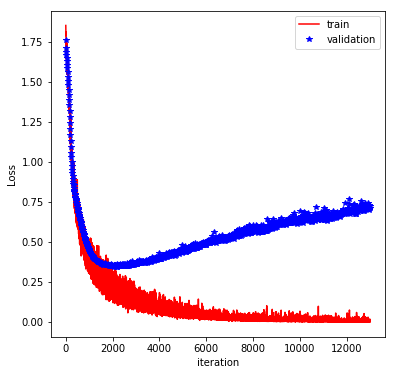

In [13]:
# Plot training and test loss
t = np.arange(iteration-1)

plt.figure(figsize = (6,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % 10 == 0], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

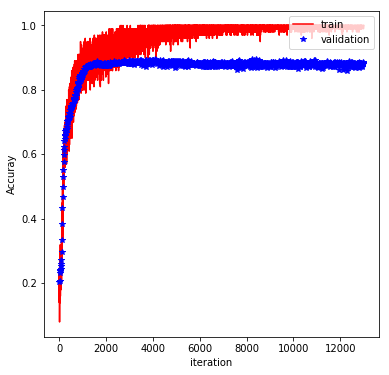

In [14]:
# Plot Accuracies
plt.figure(figsize = (6,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % 10 == 0], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Evaluate on test set

In [15]:
test_acc = []

with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints-cnn'))
    
    for x_t, y_t in get_batches(X_test, y_test, batch_size):
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1}
        
        batch_acc = sess.run(accuracy, feed_dict=feed)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints-cnn/har.ckpt
Test accuracy: 0.967778
